In [2]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import numpy as np
import matplotlib.pyplot as plt

2024-04-19 15:00:02.140019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 15:00:02.140055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 15:00:02.141413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 15:00:02.148181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 15:00:02.847485: W tensorflow/compiler/tf2

In [3]:
from glob import glob
import re
from pathlib import Path
import seaborn as sns



def read_data(train_event_files):

    pattern = r"ITM_Classifier(?:_Advanced)?_(vanilla_vit|[a-z]+)_([a-z_]+)_trainable_(True|False)_epochs_(\d+)-(\d+)"
    data = []
    for fn in train_event_files:
        nm = fn.split("/")[2]

        matches = re.match(pattern, nm)

        experiment = {
            "image_encoder": matches.groups()[0],
            "text_encoder": matches.groups()[1],
            "trainable": matches.groups()[2] == "True",
            "epochs": int(matches.groups()[3]),
            "timestamp": int(matches.groups()[4]),
        }

        for val_type, fn in zip(
            ["train", "validation"], [fn, fn.replace("train/", "validation/")]
        ):
            experiment[val_type] = {"epoch_losses": [], "epoch_binary_accuracies": []}

            fn = str(list(Path(fn).parent.glob("events*"))[0])

            for summary in summary_iterator(fn):
                for value in summary.summary.value:
                    if value.tag == "epoch_loss":
                        experiment[val_type]["epoch_losses"].append(
                            float(tf.make_ndarray(value.tensor))
                        )
                    if value.tag == "epoch_binary_accuracy":
                        experiment[val_type]["epoch_binary_accuracies"].append(
                            float(tf.make_ndarray(value.tensor))
                        )

        data.append(experiment)
    return data



Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


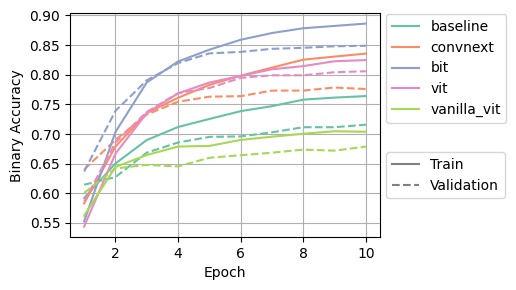

In [4]:
train_event_files = [
    "logs/fit/ITM_Classifier_Advanced_baseline_direct_embedding_trainable_False_epochs_10-1710806226/train/events.out.tfevents.1710806226.lighthouse.1282522.0.v2",
    "logs/fit/ITM_Classifier_Advanced_convnext_direct_embedding_trainable_False_epochs_10-1713391283/train/events.out.tfevents.1713391283.lighthouse.264916.0.v2",
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_False_epochs_10-1713389465/train/events.out.tfevents.1713389465.lighthouse.255203.0.v2",
    "logs/fit/ITM_Classifier_Advanced_vit_direct_embedding_trainable_False_epochs_10-1713388347/train/events.out.tfevents.1713388347.lighthouse.250314.0.v2",
    "logs/fit/ITM_Classifier_Advanced_vanilla_vit_direct_embedding_trainable_False_epochs_10-1713394950/train/events.out.tfevents.1713394950.lighthouse.287963.0.v2",
]

data = read_data(train_event_files)

def plot_training_comparison(data, labels, font_size=10, figure_size=(4, 3)):
    plt.rcParams.update({"font.size": font_size})
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(figure_size[1])
    fig.set_figwidth(figure_size[0])
    colors = sns.color_palette("Set2", len(data))

    for color, experiment, label in zip(colors, data, labels):
        for val_type in ["train", "validation"]:
            line_style = "-" if val_type == "train" else "--"
            # ax[1].plot(
            #     experiment[val_type]["epoch_losses"],
            #     line_style,
            #     color=color,
            #     label=f"{experiment['image_encoder']} {val_type}",
            # )
            # ax[1].set_ylabel("Loss")
            # ax[1].set_xlabel("Epoch")
            y = experiment[val_type]["epoch_binary_accuracies"]
            ax.plot(
                np.array(range(len(y))) + 1,
                y,
                line_style,
                color=color,
                label=f"{label} {val_type}",
            )
            ax.set_ylabel("Binary Accuracy")
            ax.set_xlabel("Epoch")

    ax.grid()

    lines = ax.get_lines()
    legend1 = fig.legend(lines[::2], labels, loc="upper left", bbox_to_anchor=(0.96, 0.96))
    legend2 = fig.legend(lines[:2], ["Train", "Validation"], loc="upper left", bbox_to_anchor=(0.96, 0.5))
    for hdl in legend2.legend_handles:
        hdl.set_color("grey")
    fig.tight_layout()

    return fig, ax

plot_training_comparison(data, [f"{experiment['image_encoder']}" for experiment in data])
plt.savefig(
    "../report/figures/image_encoder_loss_and_accuracy.png", bbox_inches="tight"
)

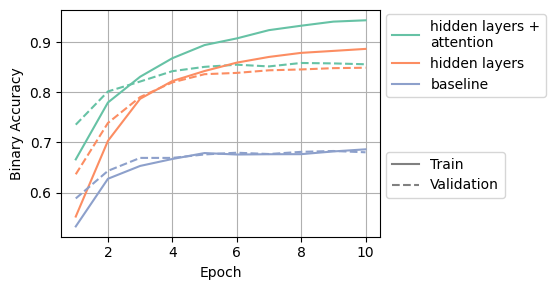

In [5]:
train_event_files = [
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_False_epochs_10-2024-04-18_14-59-29/train/events.out.tfevents.1713448769.lighthouse.421180.0.v2",
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_False_epochs_10-1713389465/train/events.out.tfevents.1713389465.lighthouse.255203.0.v2",
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_False_epochs_10-2024-04-18_15-26-09/train/events.out.tfevents.1713450369.lighthouse.430360.0.v2",
]

data = read_data(train_event_files)
classifier_names = [
    "hidden layers +\nattention",
    "hidden layers",
    "baseline",
]

plot_training_comparison(data, classifier_names)
plt.savefig("../report/figures/classifier_comparison.png", bbox_inches="tight")

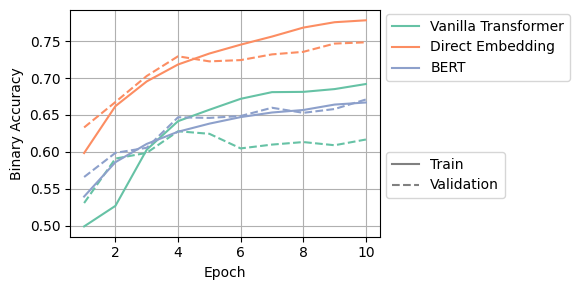

In [6]:
# train_event_files = glob(
#     "logs/fit/*baseline_*_trainable_False_epochs_10-2024-04*/train/events*"
# )

# for train_event_file in train_event_files:
#     print(train_event_file)

train_event_files = [
    "logs/fit/ITM_Classifier_Advanced_baseline_vanilla_transformer_trainable_False_epochs_10-2024-04-19_00-09-56/train/events.out.tfevents.1713481796.lighthouse.529818.0.v2",
    "logs/fit/ITM_Classifier_Advanced_baseline_direct_embedding_trainable_False_epochs_10-2024-04-19_00-02-39/train/events.out.tfevents.1713481359.lighthouse.525408.0.v2",
    "logs/fit/ITM_Classifier_Advanced_baseline_bert_trainable_False_epochs_10-2024-04-18_23-53-15/train/events.out.tfevents.1713480795.lighthouse.520902.0.v2",
]
data = read_data(train_event_files)
classifier_names = [
    "Vanilla Transformer",
    "Direct Embedding",
    "BERT",
]
plot_training_comparison(data, classifier_names)
plt.savefig("../report/figures/text_encoder_comparison.png", bbox_inches="tight")

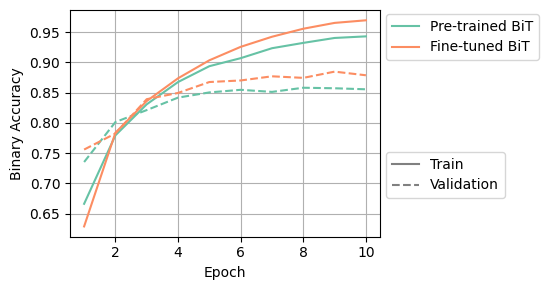

In [7]:
train_event_files = [
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_False_epochs_10-2024-04-18_14-59-29/train/events.out.tfevents.1713448769.lighthouse.421180.0.v2",
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_True_epochs_10-2024-04-19_00-39-25/train/events.out.tfevents.1713483565.lighthouse.544114.0.v2",
]
data = read_data(train_event_files)
classifier_names = [
    "Pre-trained BiT",
    "Fine-tuned BiT",
]
plot_training_comparison(data, classifier_names)
plt.savefig("../report/figures/trainable_comparison.png", bbox_inches="tight")

['logs/fit/ITM_Classifier_Advanced_baseline_direct_embedding_trainable_False_epochs_100-2024-04-19_14-39-56/train/events.out.tfevents.1713533996.lighthouse.880180.0.v2', 'logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_True_epochs_100-2024-04-19_11-08-43/train/events.out.tfevents.1713521323.lighthouse.775523.0.v2']


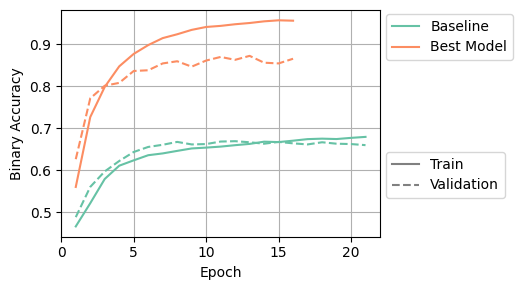

In [10]:
# best model
# 1212/1212 [==============================] - 387s 319ms/step - loss: 0.1550 - binary_accuracy: 0.9568 - val_loss: 0.6950 - val_binary_accuracy: 0.8660
# model trained!
# TESTING classifier model (showing a sample of image-text-matching predictions)...
# TEST accuracy=0.835487
# 73/73 [==============================] - 7s 102ms/step - loss: 0.3938 - binary_accuracy: 0.8338
# Tensorflow test method: Loss: 0.3937937915325165; ACCURACY: 0.8337640166282654

train_event_files = [
    "logs/fit/ITM_Classifier_Advanced_baseline_direct_embedding_trainable_False_epochs_100-2024-04-19_14-39-56/train/events.out.tfevents.1713533996.lighthouse.880180.0.v2",
]
train_event_files += glob(
    "logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_True_epochs_100-2024-04-19_11-08-43/train/events*",
)


print(train_event_files)

data = read_data(train_event_files)
classifier_names = [
    "Baseline",
    "Best Model",
]
plot_training_comparison(data, classifier_names)
plt.savefig("../report/figures/final_model_accuracy.png", bbox_inches="tight")



In [15]:
for fn in train_event_files:
    ckpts = list(Path(fn).parent.parent.glob("*checkpoint*"))
    ckpts.sort(key=lambda x: int(x.stem.split("_")[-2]))
    best_ckpt = ckpts[-1]

    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

logs/fit/ITM_Classifier_Advanced_baseline_direct_embedding_trainable_False_epochs_100-2024-04-19_14-39-56/epoch_21_checkpoint.model.keras
logs/fit/ITM_Classifier_Advanced_bit_direct_embedding_trainable_True_epochs_100-2024-04-19_11-08-43/epoch_16_checkpoint.model.keras
